In [648]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import warnings
import pickle
import datetime

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [650]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("display.float", "{:.3f}".format)
warnings.filterwarnings(action='ignore')

In [651]:
# 한글폰트적용
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
%config InlineBackend.figure_format = 'retina'

In [10]:
def print_score(actual, pred, split):
    print(f"\n{split} set modeling Result:")
    print("================================================")
    print("MAE: ", round(mean_absolute_error(actual, pred), 2))
    print("RMSE: ", round(mean_squared_error(actual, pred)**(1/2), 2))
    print("-----------------------------------------------")

# 데이터로드

In [4]:
train = pd.read_csv("train.csv", parse_dates=['일자'])
test = pd.read_csv("test.csv", parse_dates=['일자'])

In [654]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0,"모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐어채무침 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 청포묵무침 요구르트 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 포기김치 (김치:국내산)",1039,331
1,2016-02-02,화,2601,50,173,319,0,"모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌개 시래기조림 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무침 요구르트 배추겉절이 (배추,고추가루:국내산)","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무침 바나나 포기김치 (배추,고추가루:국내산)",867,560
2,2016-02-03,수,2601,56,180,111,0,"모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국 느타리호박볶음 포기김치 (배추,고추가루:국내산)","카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 견과류조림 요구르트 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기전 (돼지고기:국내산) 새송이버섯볶음 포기김치 (배추,고추가루:국내산)",1017,573
3,2016-02-04,목,2601,104,220,355,0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국 멸치볶음 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 요구르트 포기김치 (배추,고추가루:국내산)","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포기김치 (배추,고추가루:국내산)",978,525
4,2016-02-05,금,2601,278,181,34,0,"모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방풍나물 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채 청경채무침 요구르트 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:국내산) 감자소세지볶음 콩나물무침 포기김치 (배추,고추가루:국내산)",925,330


변수
* 일자
* 요일
* 본사 정원 수
* 본사 휴가자 수
* 본사 출장자 수
* 본사 시간외 근무 명령서 승인 건수
* 현 본사 소속 재택 근무자 수
* 조식 메뉴
* 중식 메뉴	
* 석식 메뉴
* 중식계
* 석식계

# EDA

In [656]:
print('Information on train set\n')
train.info()
print("\n----------------------------------------\n")
print('Information on test set\n')
test.info()

Information on train set

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   object        
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   int64         
 7   조식메뉴            1205 non-null   object        
 8   중식메뉴            1205 non-null   object        
 9   석식메뉴            1205 non-null   object        
 10  중식계             1205 non-null   int64         
 11  석식계             1205 non-null   int64         
dtypes: datetime64[ns](1), int64(7), object(4)
memory usage: 113.1+ KB

----------------------------------------

Information on test set



In [657]:
# Number of features and observations
train.shape
test.shape

(1205, 12)

(50, 10)

In [5]:
# Basic statistics
train.describe()

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계
count,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000
mean,2807.815768,157.913693,241.142739,274.117012,43.506224,890.334440,461.772614
std,171.264404,144.190572,43.532298,246.239651,109.937400,209.505057,139.179202
min,2601.000000,23.000000,41.000000,0.000000,0.000000,296.000000,0.000000
25%,2645.000000,71.000000,217.000000,4.000000,0.000000,758.000000,406.000000
50%,2760.000000,105.000000,245.000000,299.000000,0.000000,879.000000,483.000000
75%,2962.000000,185.000000,272.000000,452.000000,0.000000,1032.000000,545.000000
max,3305.000000,1224.000000,378.000000,1044.000000,533.000000,1459.000000,905.000000


In [660]:
# 결측치 확인
train.isna().sum().max()
test.isna().sum().max()

0

0

<AxesSubplot:xlabel='중식계', ylabel='Count'>

<AxesSubplot:xlabel='석식계', ylabel='Count'>

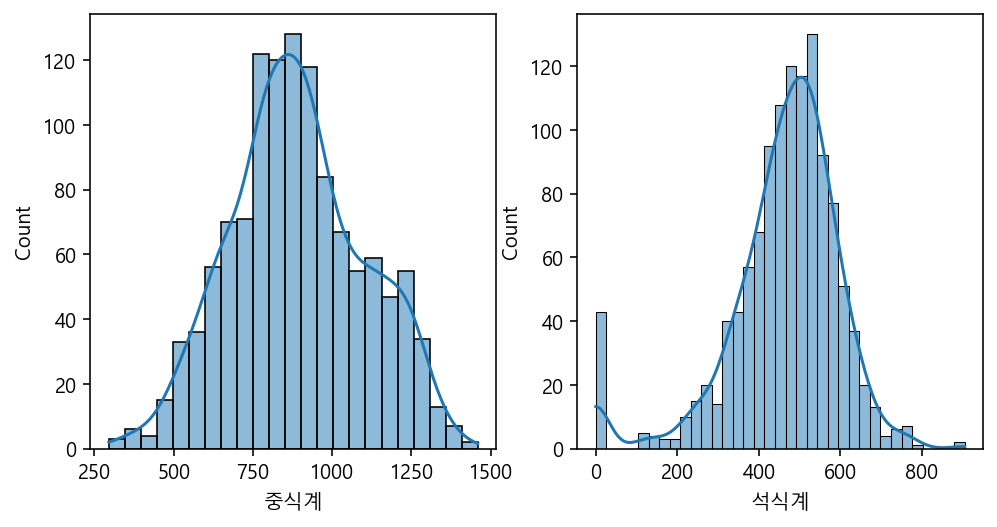

In [661]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.histplot(x='중식계', data=train, ax=axes[0], kde=True)
sns.histplot(x='석식계', data=train, ax=axes[1], kde=True)

타겟변수인 중식계와 석식계 모두 정규분포를 이루고 있고 중식계와 달리 석식은 0인 경우가 많음을 알 수 있습니다.

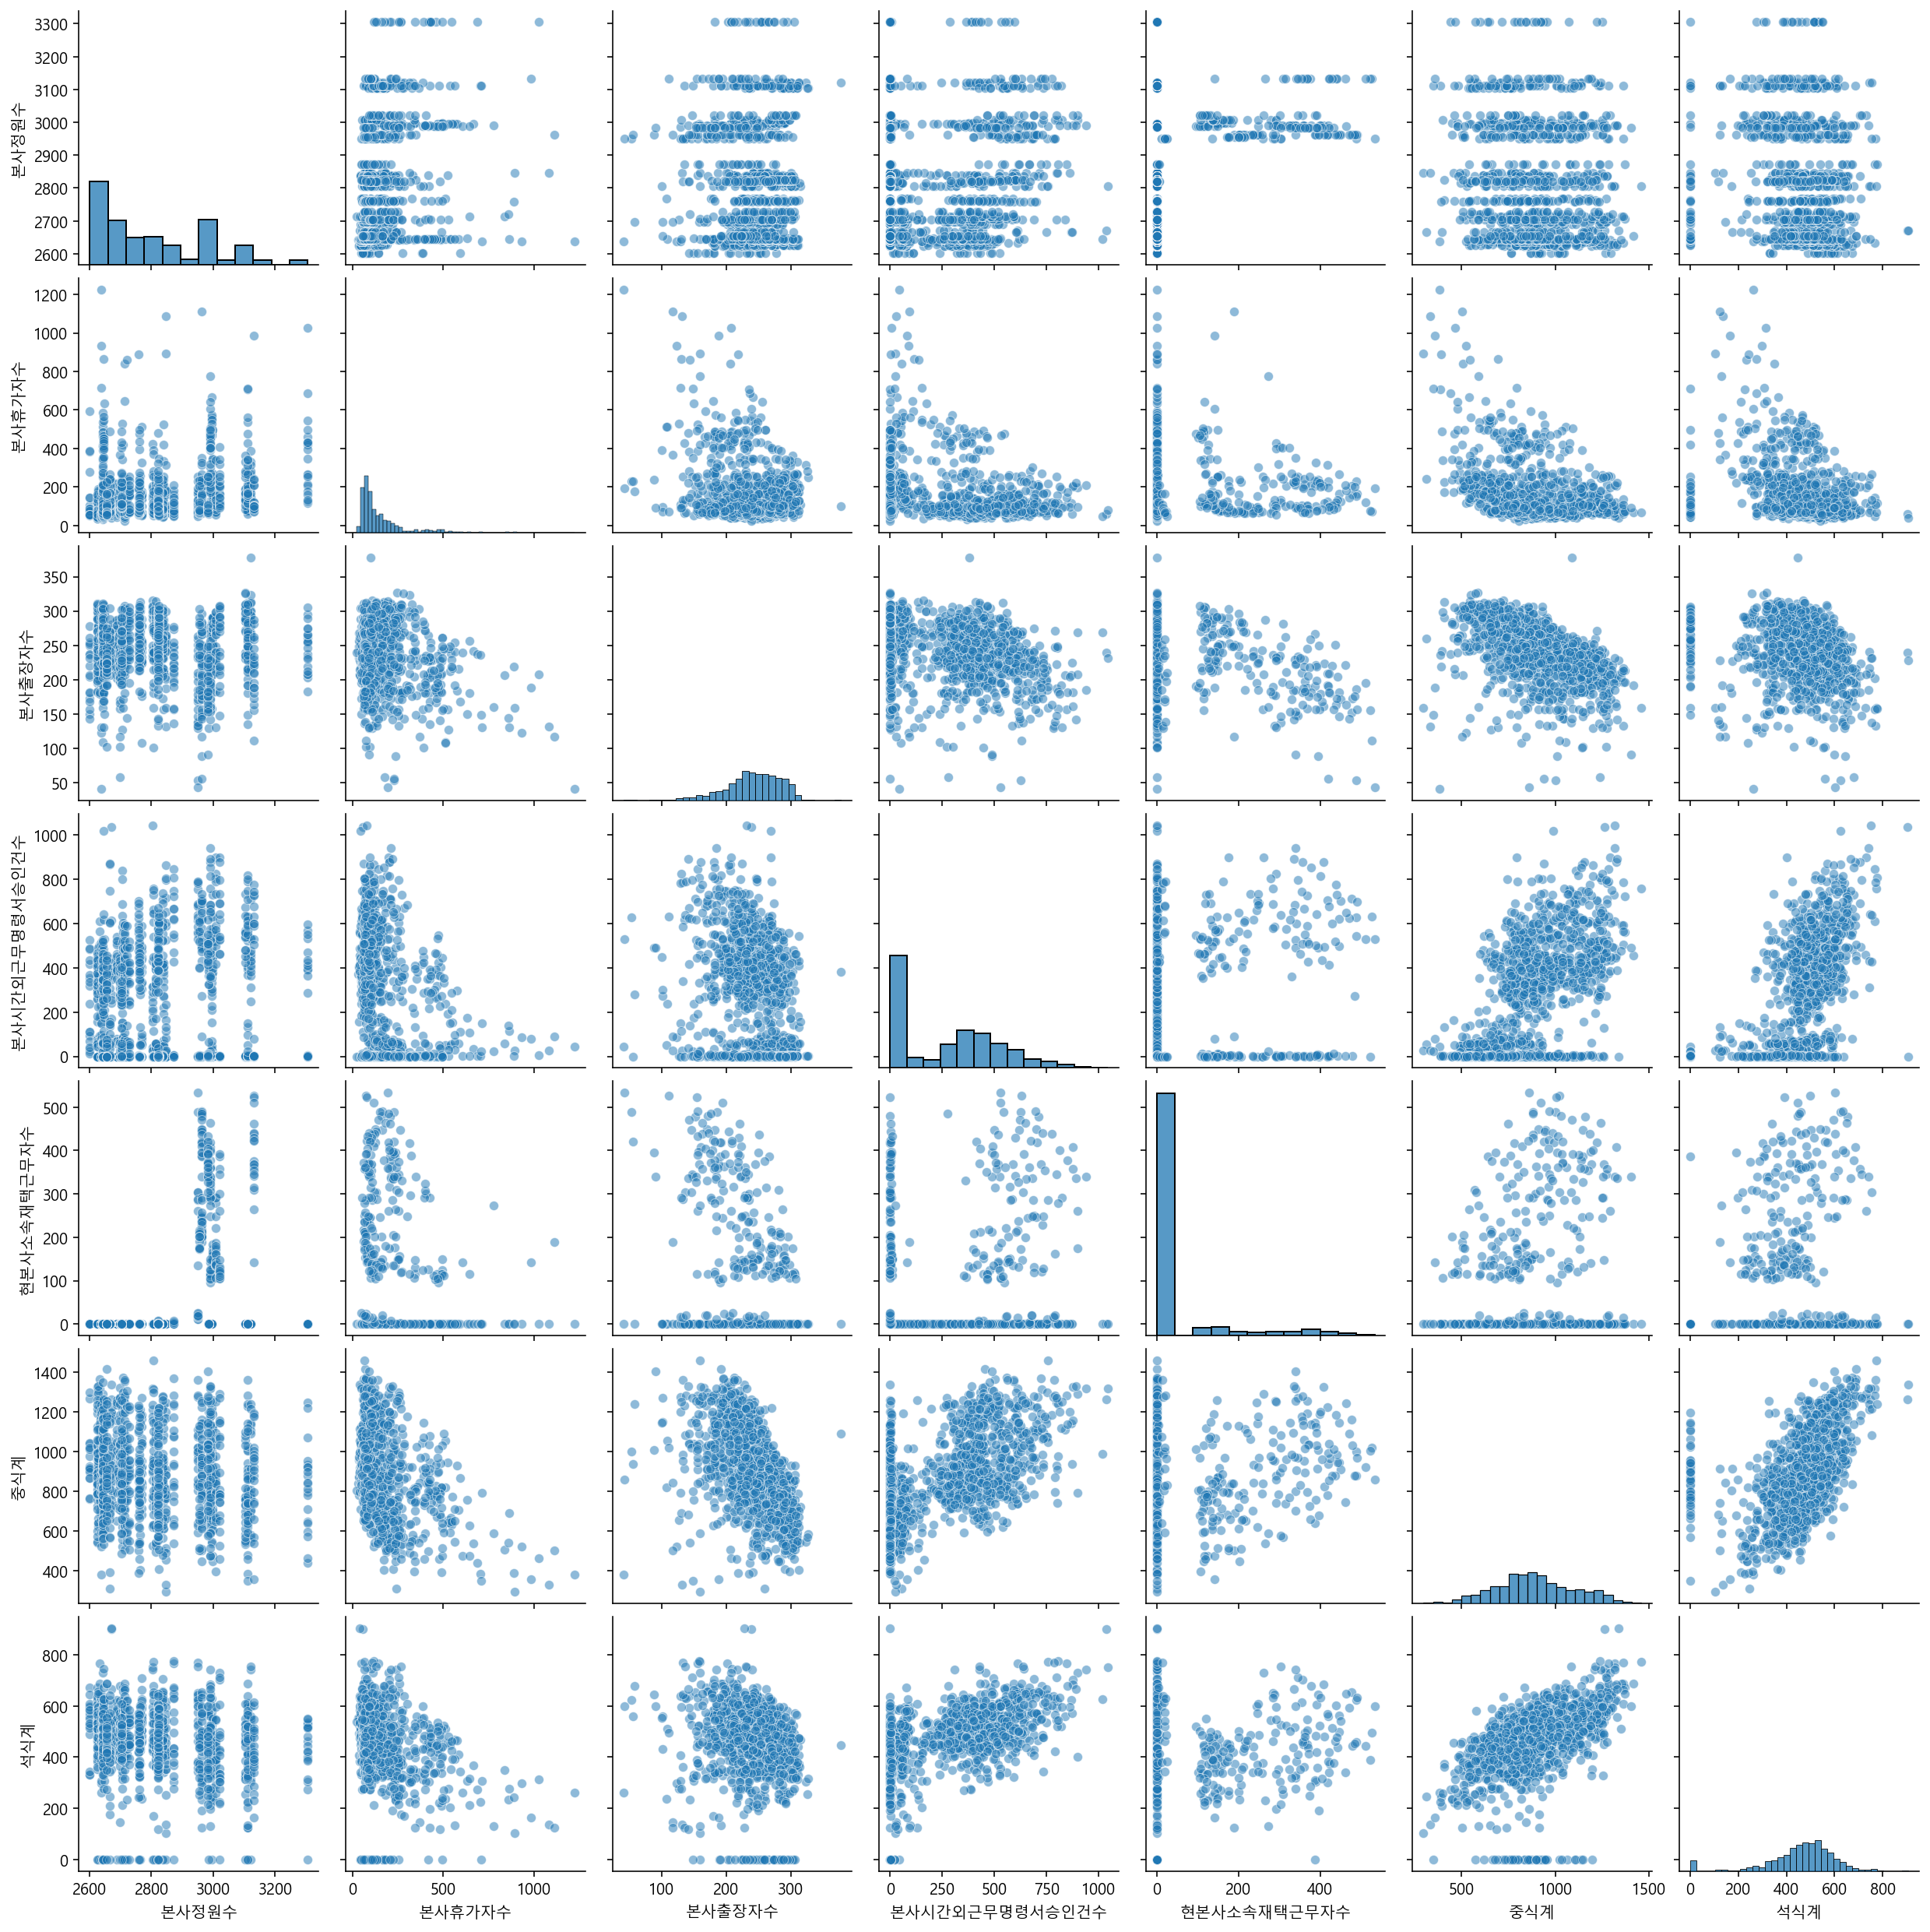

In [662]:
sns.pairplot(train, plot_kws={'alpha':0.5})

In [663]:
outliers = (train['본사출장자수']>300) & (train['중식계']>1000)
train[outliers]

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
906,2019-10-22,화,3121,99,378,381,0,"모닝롤/야채샌드 우유/주스 스크램블에그 잣죽/쌀밥 (쌀:국내산,쇠고기:호주) 소고기무국 두부쑥갓무침 포기김치 (김치:국내산)",쌀밥/잡곡밥 (쌀:국내산) 얼큰순두부찌개 짬뽕불고기 잡채 도토리묵무침 포기김치 (김치:국내산),김밥 (쌀:국내산) 잔치국수 떡볶이 김말이튀김 음료 배추겉절이 (김치:국내산),1090,446


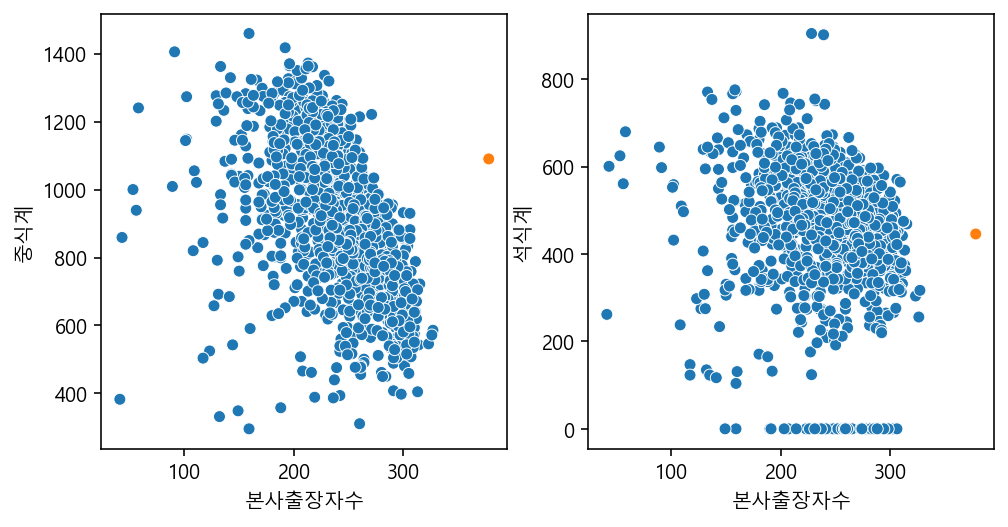

In [664]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
g1 = sns.scatterplot(x='본사출장자수', y='중식계', ax=axes[0], data=train, hue=outliers, legend=False)
g2 = sns.scatterplot(x='본사출장자수', y='석식계', ax=axes[1], data=train, hue=outliers, legend=False)

모델링에 영향을 줄 수 있는 아웃라이어를 선별하였습니다.

<Figure size 504x504 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, '변수간 상관관계')

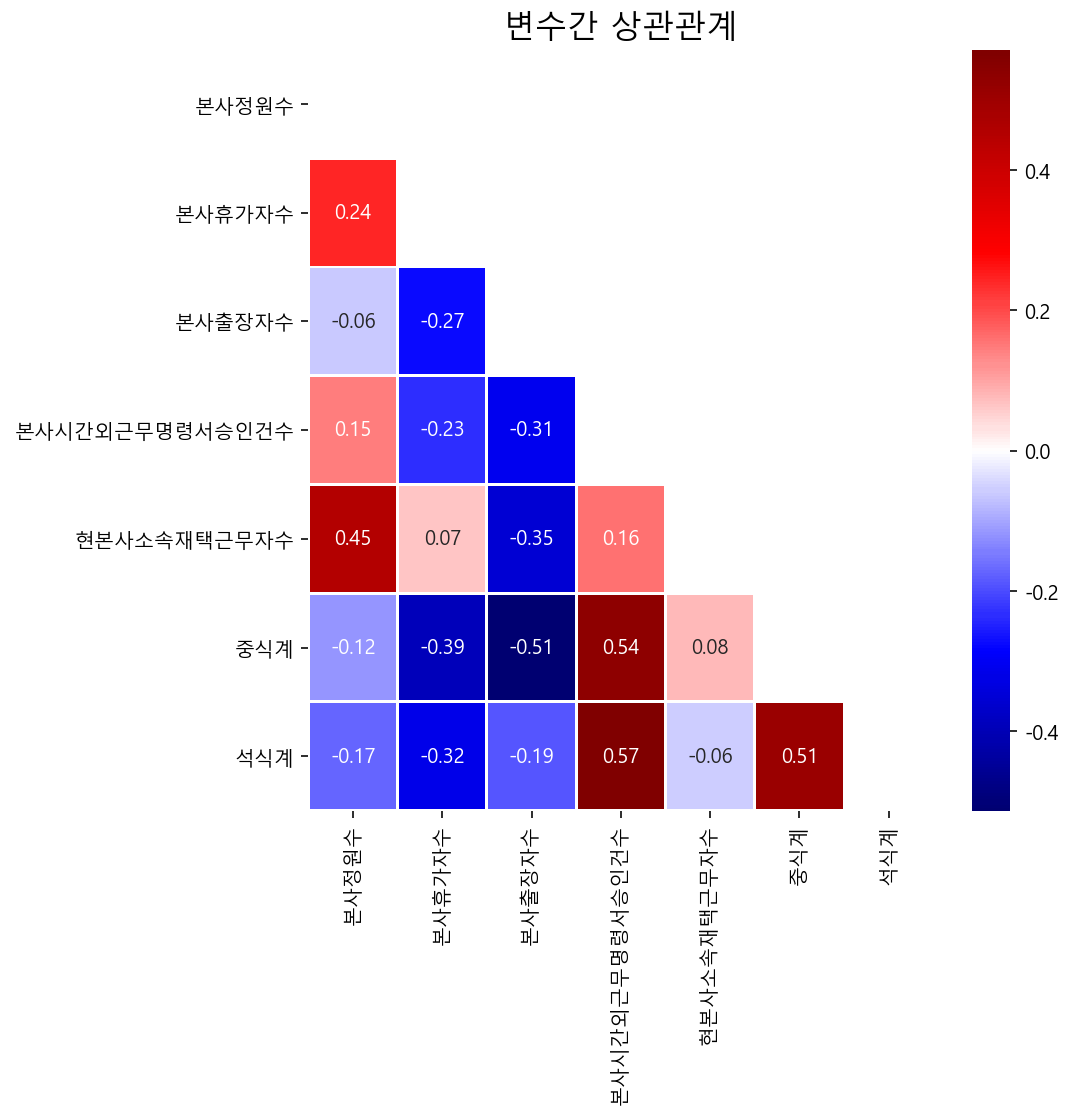

In [665]:
corr = train.corr()

plt.figure(figsize=(7, 7))
mask_corr = np.triu(np.ones_like(corr, dtype='bool'))
sns.heatmap(corr,
           mask=mask_corr,
           center=0,
           cmap='seismic',
           linewidths=1,
           fmt='.2f',
           annot=True)
plt.title('변수간 상관관계', fontdict={'fontsize':16})

1. 타겟변수와 상관관계가 높은 예측변수들
>본사 휴가자 수 & 중식계, 석식계 (-0.39, -0.32) <br>
본사 출장자 수  & 중식계, 석식계 (-0.51, -0.19) <br>
본사 시간외 근무 명령서 승인 건수 & 중식계, 석식계 (0.54, 0.57)

2. 중식계와 석식계는 양의 상관관계를 가진다.
3. 예측변수들 간의 상관관계는 미미하다.

<AxesSubplot:xlabel='요일', ylabel='중식계'>

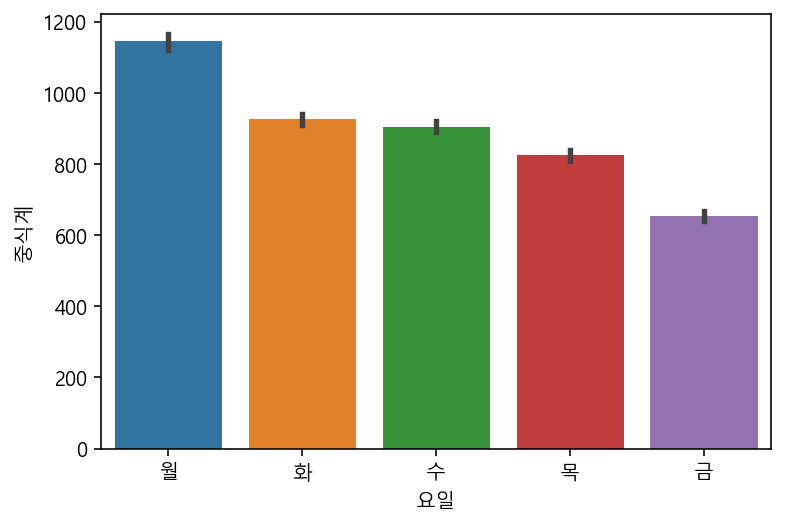

In [666]:
sns.barplot(data=train, x='요일', y='중식계')

구내식당의 점심시간은 월요일에 가장 붐비고 금요일에 가장 한산한 것을 알 수 있습니다. 

<AxesSubplot:xlabel='요일', ylabel='석식계'>

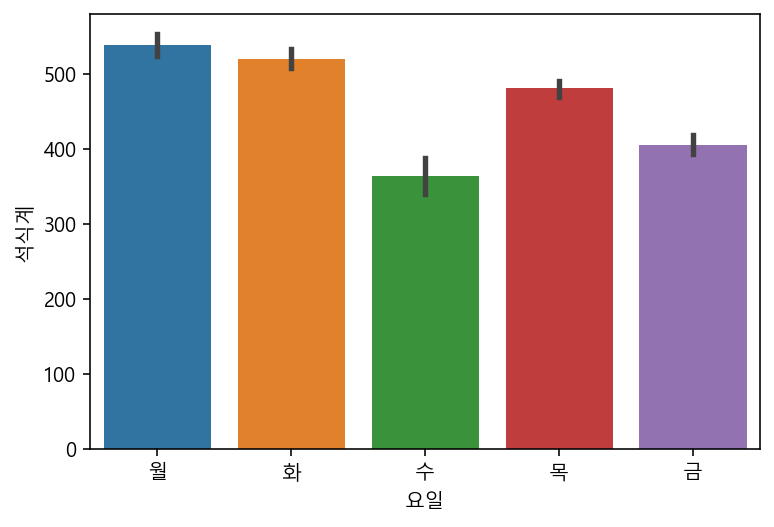

In [667]:
sns.barplot(data=train, x='요일', y='석식계')

수요일에 석식계가 유달리 낮은 것을 알 수 있습니다.

In [668]:
train[['조식메뉴', '중식메뉴', '석식메뉴']].head(10)
train[['조식메뉴', '중식메뉴', '석식메뉴']].tail(10)

,조식메뉴,중식메뉴,석식메뉴
0,"모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐어채무침 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 청포묵무침 요구르트 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 포기김치 (김치:국내산)"
1,"모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌개 시래기조림 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무침 요구르트 배추겉절이 (배추,고추가루:국내산)","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무침 바나나 포기김치 (배추,고추가루:국내산)"
2,"모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국 느타리호박볶음 포기김치 (배추,고추가루:국내산)","카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 견과류조림 요구르트 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기전 (돼지고기:국내산) 새송이버섯볶음 포기김치 (배추,고추가루:국내산)"
3,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국 멸치볶음 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 요구르트 포기김치 (배추,고추가루:국내산)","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포기김치 (배추,고추가루:국내산)"
4,"모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방풍나물 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채 청경채무침 요구르트 포기김치 (배추,고추가루:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:국내산) 감자소세지볶음 콩나물무침 포기김치 (배추,고추가루:국내산)"
5,팬케익/찐빵 우유/두유/주스 계란후라이 견과류죽/쌀밥 (쌀:국내산) 감자찌개 명엽채무침 포기김치 (김치:국내산),"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 시래기국 훈제오리구이 도토리묵무침 쌈무/양파절임 요구르트 포기김치 (김치:국내산)","참치회덮밥 (쌀,현미흑미:국내산) 맑은국 군만두 과일샐러드 락교 포기김치 (김치:국내산)"
6,모닝롤/야채샌드 우유/두유/주스 계란후라이 고구마죽/쌀밥 (쌀:국내산) 봄동된장국 숙주나물 포기김치 (김치:국내산),"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 꽃게탕 돈육굴소스볶음 옥수수전 유채나물 요구르트 포기김치 (김치:국내산)","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치콩나물국 미니함박 어묵볶음 물파래무침 깍두기 (김치:국내산)"
7,모닝롤/치즈프레즐 우유/두유/주스 계란후라이 잣죽/쌀밥 (쌀:국내산) 민물새우찌개 콩조림 포기김치 (김치:국내산),쌀밥/잡곡밥 (쌀:국내산) 시금치국 닭감자조림 (닭고기:국내산) 연두부*양념장 콩나물무침 요구르트 포기김치 (김치:국내산),"쌀밥/잡곡밥 (쌀:국내산) 홍합미역국 등갈비김치찜 (돼지고기,김치:국내산) 임연수구이 브로컬리초장 포기김치 (김치:국내산)"
8,모닝롤/마늘빵 우유/두유/주스 계란후라이 단호박죽/쌀밥 (쌀:국내산) 어묵국 김구이 포기김치 (김치:국내산),쌀밥/잡곡밥 (쌀:국내산) 쇠고기무국 (쇠고기:호주산) 탕수어 (동태:러시아산) 오징어숙회무침 취나물 요구르트 포기김치 (김치:국내산),쌀밥/잡곡밥 (쌀:국내산) 된장찌개 쇠불고기 (쇠고기:호주산) 해파리겨자채 봄동무침 포기김치 (김치:국내산)
9,모닝롤/참치샌드 우유/두유/주스 계란후라이 흑임자죽/쌀밥 (쌀:국내산) 북어계란국 무생채 포기김치 (김치:국내산),쌀밥/잡곡밥 (쌀:국내산) 냉이된장국 쇠고기장조림 (쇠고기:호주산) 통도라지구이 치커리무침 요구르트 포기김치 (김치:국내산),볶음밥*자장소스 (쌀:국내산) 맑은국 새우또띠아 쨔샤이무침 요플레 포기김치 (김치:국내산)


,조식메뉴,중식메뉴,석식메뉴
1195,모닝롤/치즈팡샌드 우유/주스 계란후라이/찐계란 양송이스프/흑미밥 들깨무채국 매운사태조림 콥샐러드/양상추샐러드 포기김치,쌀밥/흑미밥/찰현미밥 시금치된장국 돈육두루치기 타코야끼 상추쌈 겉절이김치 양상추샐러드*흑임자D,알리오올리오/추가밥 가쓰오장국 수제치킨까스 팽이버섯부추무침 산고추지무침 무생채
1196,모닝롤/블루베리크림치즈베이글 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 동태탕 건파래볶음 양상추샐러드 포기김치,쌀밥/차조밥/찰현미밥 콩나물김칫국 소갈비찜 두부까스*칠리소스 매운호박볶음 포기김치 지중해샐러드,흑미밥 홍합탕 오삼불고기 어묵깻잎전 오이달래무침 포기김치
1197,모닝롤/허니브레드 우유/주스/커피 계란후라이/찐계란 낙지죽/흑미밥 황태국 시래기지짐 양상추샐러드 포기김치,쌀밥/흑미밥/찰현미밥 뼈없는감자탕 고등어구이*와사비장 채소스틱*쌈장 솎음열무나물 석박지 양상추샐러드*딸기D,흑미밥 순두부백탕 닭볶음탕 비빔만두채소무침 명엽채볶음 포기김치
1198,모닝롤/녹차카스테라 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 꽃게탕 파래김*달래양념장 양상추샐러드 포기김치,쌀밥/흑미밥/찰현미밥 어묵국 춘천닭갈비 감자채카레볶음 청경채나물 포기김치/바나나 그린샐러드*매실D,흑미밥 배추된장국 낙지미나리볶음 메추리알풋고추조림 시금치나물무침 깍두기
1199,모닝롤/땅콩샌드 우유/주스 계란후라이/찐계란 콩죽/흑미밥 근대된장국 토란탕 양상추샐러드 포기김치,쌀밥/기장밥/찰현미밥 맑은콩나물국 삼겹살김치찜 떡잡채 치커리오이무침 포기김치 그린샐러드*키위요거트D,흑미밥 북어짬뽕국 만가닥버섯불고기 건새우호박채전 삼색귤소스무침 포기김치
1200,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘종숙회 양상추샐러드 포기김치,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치 양상추샐러드*오리엔탈D,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치
1201,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶음 양상추샐러드 깍두기,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐러드*파인D,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치
1202,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조림 양상추샐러드 포기김치,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러드*자몽D,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치
1203,모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분홍소세지구이*케찹 양상추샐러드 포기김치,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄동겉절이/양념김 양상추샐러드*오렌지D,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치
1204,모닝롤/야채샌드 우유/주스 계란후라이/찐계란 참치죽/흑미밥 홍합탕 애호박새우젓볶음 양상추샐러드 포기김치,쌀밥/귀리밥/찰현미밥 들깨미역국 교촌간장치킨 옥수수콘치즈구이 가지고추장무침 포기김치/요구르트 양배추샐러드*사우전D,(New)할라피뇨멸치주먹밥 잔치국수 수제고기육전 쑥갓나물 양파초절임 깍두기


1. 중식메뉴와 석식메뉴는 보통 6가지 메뉴로 구성되어 있으며 음료 등이 제공되는 경우에는 7가지를 제공하는 것으로 보입니다.
2. 메뉴구성 <br>

>첫번째 메뉴: 밥류<br>
두번 째 메뉴: 국류<br>
세번 째 메뉴: 메인반찬<br>
네번 째 메뉴: 서브반찬<br>
다섯번 째 메뉴: 채소반찬<br>
여섯번 째 메뉴: 김치류

3. 가정 <br>
 * 밥, 국, 메인반찬의 메뉴가 영향이 가장 크다. <br> 
 * 괄호에 적힌 원산지는 영향을 미치지 않는다 <br>
 * 조식메뉴는 중식계와 석식계에 영향을 미치지 않는다

In [669]:
# 석식계가 0인 데이터
train[train['석식계'] == 0].head()
train[train['석식계'] == 0].tail()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
204,2016-11-30,수,2689,68,207,0,0,모닝롤/카스텔라 우유/주스 스크램블에그 누룽지탕/쌀밥 (쌀:국내산) 고추장찌개 김자반 포기김치 (김치:국내산),나물비빔밥 (쌀:국내산) 가쯔오장국 치킨핑거*요거트D 감자샐러드 오복지무침 포기김치 (김치:국내산),*,1109,0
224,2016-12-28,수,2705,166,225,0,0,모닝롤/고구마파이 우유/주스 스크램블에그 누룽지탕/쌀밥 (쌀:국내산) 북어계란국 느타리호박볶음 포기김치 (김치:국내산),콩나물밥 (쌀:국내산) 가쯔오장국 미트볼케찹조림 꽃맛살샐러드 군고구마 배추겉절이 (김치:국내산),*,767,0
244,2017-01-25,수,2697,79,203,0,0,모닝롤/토마토샌드 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 두부젓국찌개 김자반 포기김치 (김치:국내산),카레덮밥 (쌀:국내산) 맑은국 유린기 개성감자만두 오이사과무침 포기김치 (김치:국내산),*,720,0
262,2017-02-22,수,2632,75,252,0,0,모닝롤/브라우니 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 꽃게탕 명엽채무침 포기김치 (김치:국내산),나물비빔밥 (쌀:국내산) 유부장국 생선까스*탈탈소스 파스타샐러드 마늘쫑볶음 알타리김치 (김치:국내산),*,1065,0
281,2017-03-22,수,2627,53,235,0,0,모닝롤/찐빵 우유/주스 계란후라이 김치죽/쌀밥 (쌀:국내산) 콩나물국 김실파무침 포기김치 (김치:국내산),쌀밥/잡곡밥 (쌀:국내산) 돈육김치찌개 유린기 비엔나볶음 세발나물 깍두기 (김치:국내산),*,953,0


,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
932,2019-11-27,수,3104,134,288,1,0,모닝롤/단팥빵 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 무채국 (우민찌:호주산) 문어꽈리초조림 포기김치 (김치:국내산),나물비빔밥 (쌀:국내산) 맑은국 감자치즈구이 군만두 치커리유자청생채 포기김치 (김치:국내산),*,732,0
955,2019-12-31,화,3111,709,149,22,0,모닝롤/야채샌드 우유/주스 스크램블에그 고구마죽/쌀밥 (쌀:국내산) 열무된장국 두부쑥갓무침 (두부:수입산) 포기김치 (김치:국내산),쌀밥/잡곡밥 (쌀:국내산) 배추된장국 닭볶음탕 (닭:국내산) 부추깻잎전 양배추쌈*쌈장 포기김치 (김치:국내산),*,349,0
973,2020-01-29,수,2821,101,214,4,0,"모닝롤/야채샌드 우유/주스 스크램블에그 고구마죽/쌀밥 (쌀:국내산) 꽃게탕 미역줄기볶음 포기김치 (배추,고춧가루:국산)","콩나물밥*양념장 (쌀:국내산,소고기:호주) 가쯔오장국 치킨핑거 (닭:국내산) 꽃맛살샐러드 청경채생채 포기김치 (배추,고춧가루:국산)",자기개발의날,1197,0
993,2020-02-26,수,2872,109,190,4,0,"모닝롤/고구마파이 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 홍합탕 감자채볶음 포기김치 (배추,고추가루:국내산)","낙지비빔밥 (쌀:국내,낙지:중국산) 팽이장국 치킨텐더*콘소스D (닭:국내산) 과일샐러드 마늘쫑무침 포기김치 (배추,고추가루:국내산)",자기개발의날,1105,0
1166,2020-11-25,수,3021,206,191,3,387,모닝롤/베이글 우유/주스 계란후라이 녹두죽/흑미밥 아귀지리탕 돈사태찜 양상추샐러드 포기김치,쌀밥/흑미밥/찰현미밥 콩비지김치찌개 해물누룽지탕 탕평채 고추장감자조림 깍두기/수제과일잼샌드 양상추샐러드*요거트D,＜자기 계발의 날＞,1146,0


앞서 Scatter plot에서 석식계가 0인 데이터가 많음을 확인하고 데이터를 살펴보았습니다. 주로 매달 마지막 주 수요일은 자기개발의 날을 주어 석식을 제공하지 않음을 알 수 있습니다. 그렇기 때문에 수요일은 다른 요일에 비해 석식계의 평균이 낮았습니다.

# Feature engineering

In [671]:
test['중식계'] = np.nan
test['석식계'] = np.nan

train['Index'] = 'Train'
test['Index'] = 'Test'
all_data = pd.concat([train, test], ignore_index=True)

변수 엔지니어링을 위해 트레인 데이터 세트와 테스트 데이터 세트를 합칩니다.

**메뉴 변수 엔지니어링**

In [672]:
lunch_origin = all_data['중식메뉴'].str.split(' ')

lunch=[]
for menu in lunch_origin:
    # Whitespace을 기준으로 문자열 나누기
    temp = ' '.join(menu).split() 
    
    # 괄호 안에 적힌 원산지 표시 등 제거
    for item in temp:            
        if '(' in item:
            temp.remove(item)
    
    lunch.append(temp)

In [673]:
for menu in lunch:
    if '쌀밥' in menu[0]:
        menu[0] = '쌀밥'

제공된 메뉴 변수를 각각의 메뉴 아이템별로 나누고, 원산지 표시 등을 제거 하였으며, 쌀밥/잡곡밥, 쌀밥/흑미밥 등의 밥 메뉴를 '쌀밥'으로 통일하는 전처리를 하였습니다.

In [674]:
lunch[:10]

[['쌀밥', '오징어찌개', '쇠불고기', '계란찜', '청포묵무침', '요구르트', '포기김치'],
 ['쌀밥', '김치찌개', '가자미튀김', '모둠소세지구이', '마늘쫑무침', '요구르트', '배추겉절이'],
 ['카레덮밥', '팽이장국', '치킨핑거', '쫄면야채무침', '견과류조림', '요구르트', '포기김치'],
 ['쌀밥', '쇠고기무국', '주꾸미볶음', '부추전', '시금치나물', '요구르트', '포기김치'],
 ['쌀밥', '떡국', '돈육씨앗강정', '우엉잡채', '청경채무침', '요구르트', '포기김치'],
 ['쌀밥', '시래기국', '훈제오리구이', '도토리묵무침', '쌈무/양파절임', '요구르트', '포기김치'],
 ['쌀밥', '꽃게탕', '돈육굴소스볶음', '옥수수전', '유채나물', '요구르트', '포기김치'],
 ['쌀밥', '시금치국', '닭감자조림', '연두부*양념장', '콩나물무침', '요구르트', '포기김치'],
 ['쌀밥', '쇠고기무국', '탕수어', '오징어숙회무침', '취나물', '요구르트', '포기김치'],
 ['쌀밥', '냉이된장국', '쇠고기장조림', '통도라지구이', '치커리무침', '요구르트', '포기김치']]

In [675]:
lunch1 = []
lunch2 = []
lunch3 = []

for listin in lunch:
    lunch1.append(listin[0])
    lunch2.append(listin[1])
    lunch3.append(listin[2])

In [676]:
lunch1[:10]
lunch2[:10]
lunch3[:10]

['쌀밥', '쌀밥', '카레덮밥', '쌀밥', '쌀밥', '쌀밥', '쌀밥', '쌀밥', '쌀밥', '쌀밥']

['오징어찌개',
 '김치찌개',
 '팽이장국',
 '쇠고기무국',
 '떡국',
 '시래기국',
 '꽃게탕',
 '시금치국',
 '쇠고기무국',
 '냉이된장국']

['쇠불고기',
 '가자미튀김',
 '치킨핑거',
 '주꾸미볶음',
 '돈육씨앗강정',
 '훈제오리구이',
 '돈육굴소스볶음',
 '닭감자조림',
 '탕수어',
 '쇠고기장조림']

In [677]:
all_data['lunch1'] = lunch1
all_data['lunch2'] = lunch2
all_data['lunch3'] = lunch3

메뉴를 밥, 국, 메인반찬 아이템으로 각각 나누어 준 후 데이터 프레임에 추가 하였습니다.

In [678]:
# 메뉴명에 포함된 특수문자 제거
all_data['lunch1'] = all_data['lunch1'].str.replace(r'([/*]\w+)', '')

# 한번만 출현한 음식은 New로 분류
counts = all_data['lunch1'].value_counts()
mask = all_data['lunch1'].isin(counts[counts == 1].index)
all_data['lunch1'][mask] = 'New'

In [679]:
all_data['lunch1'].value_counts()

쌀밥          1051
곤드레밥          30
콩나물밥          30
New           23
카레덮밥          18
나물비빔밥         15
단호박영양밥        10
비빔밥            9
김치제육덮밥         8
카레라이스          8
낙지비빔밥          7
산채비빔밥          6
짜장덮밥           6
열무보리비빔밥        5
마파두부덮밥         5
봄나물비빔밥         4
짜장밥            4
열무비빔밥          3
소불고기덮밥         3
단호박카레라이스       2
참치회덮밥          2
<초복특식>         2
전주비빔밥          2
김치볶음밥          2
Name: lunch1, dtype: int64

In [680]:
# 메뉴명에 포함된 특수문자 및 괄호 제거
all_data['lunch2'] = all_data['lunch2'].str.replace(r'([/*]\w+)', '')\
    .str.replace(r'\(\w*\)', '')

# 한번만 출현한 음식은 New로 분류
counts = all_data['lunch2'].value_counts()
mask = all_data['lunch2'].isin(counts[counts == 1].index)
all_data['lunch2'][mask] = 'New'

In [681]:
# 메뉴명에 포함된 특수문자 제거
all_data['lunch3'] = all_data['lunch3'].str.replace(r'([/*&%]\w+)', '')

# 한번만 출현한 음식은 New로 분류
counts = all_data['lunch3'].value_counts()
mask = all_data['lunch3'].isin(counts[counts == 1].index)
all_data['lunch3'][mask] = 'New'

메뉴명에 포함된 특수 문자 등을 제거하고 여태 한번만 제공된 메뉴들은 'New'로 클래스를 변환시켜 주었습니다.

**석식메뉴에도 적용하기**

In [682]:
dinner_origin = all_data['석식메뉴'].str.split(' ')

In [683]:
dinner = []
for menu in dinner_origin:
    temp = ' '.join(menu).split()
    for item in temp:
        if '(' in item:
            temp.remove(item)
    
    dinner.append(temp)

In [684]:
for menu in dinner:
    if len(menu) < 4:
        print(menu)

['*']
['*']
['*']
['*']
['*']
['*']
['자기계발의날']
['*자기계발의날*']
['가정의날']
['*']
['*']
['*']
['*']
['*']
['*']
['*']
['*']
[]
[]
['*']
['*']
[]
['*']
[]
['자기계발의날']
['*']
['자기계발의날']
['자기개발의날']
['*', '자기계발의날', '*']
['*', '자기개발의날', '*']
['*', '자기계발의날', '*']
['*', '자기개발의날', '*']
['*', '자기개발의날', '*']
['자기계발의날']
['*']
['*']
['*']
['*']
['*']
['자기개발의날']
['자기개발의날']
['＜자기', '계발의', '날＞']


석식메뉴는 중식메뉴와는 달리 자기개발의날이 있음을 확인하였습니다.

In [685]:
all_data['자기개발의날'] = all_data['석식메뉴'].str.len() <30

자기개발의 날로 분류할 수 있는 변수를 테이블에 추가하였습니다.

In [686]:
all_data[(all_data['자기개발의날'] == False) & (all_data['석식계'] == 0)]

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,Index,lunch1,lunch2,lunch3,자기개발의날
410,2017-09-27,수,2642,70,265,0,0,모닝롤/단팥빵 우유/주스 계란후라이 크림누룽지탕/쌀밥 (쌀:국내산) 아욱국 명엽채무침 포기김치 (김치:국내산),쌀밥/잡곡밥 (쌀:국내산) 콩나물국 삼겹살구이 어묵볶음 상추파무침 포기김치 (김치:국내산),쌀밥/잡곡밥 (쌀:국내산) 된장찌개 미니함박조림 계란말이 비름나물 포기김치 (김치:국내산),1023.000,0.000,Train,쌀밥,콩나물국,삼겹살구이,False
502,2018-02-14,수,2707,418,159,0,0,모닝롤/고구마파이 우유/주스 계란후라이 땅콩죽/쌀밥 (쌀:국내산) 콩나물국 어묵볶음 포기김치 (김치:국내산),쌀밥/잡곡밥 (쌀:국내산) 떡국 버섯불고기 오징어숙회무침 취나물 배추겉절이 (김치:국내산),쌀밥/잡곡밥 (쌀:국내산) 쇠고기무국 고추잡채*꽃빵 계란찜 오이무침 포기김치 (김치:국내산),850.000,0.000,Train,쌀밥,떡국,버섯불고기,False


In [687]:
outliers2 = (all_data['자기개발의날'] == False) & (all_data['석식계'] == 0)

자기개발의 날이 아니면서 석식계가 0인 데이터는 아웃라이어로 취급합니다.

In [688]:
dinner1 = []
dinner2 = []
dinner3 = []

for menu in dinner:
    if len(menu) > 4:
        dinner1.append(menu[0])
        dinner2.append(menu[1])
        dinner3.append(menu[2])
    
    else:
        dinner1.append(np.nan)
        dinner2.append(np.nan)
        dinner3.append(np.nan)

자기개발의 날에는 저녁 dinner1(밥), dinner2(국), dinner3(메인반찬) 을 결측치로 처리 합니다.

In [689]:
all_data['dinner1'] = dinner1
all_data['dinner2'] = dinner2
all_data['dinner3'] = dinner3

In [690]:
# 특수문자 등 제거
all_data['dinner1'] = all_data['dinner1'].str.replace(r'.*쌀밥|흑미밥.*', '쌀밥')\
    .str.replace(r'[*/]\w+', '')


# 한번만 출현한 음식은 New로 분류
counts = all_data['dinner1'].value_counts()
mask = all_data['dinner1'].isin(counts[counts == 1].index)
all_data['dinner1'][mask] = 'New'

In [692]:
# 메뉴명에 포함된 특수문자 제거
all_data['dinner2'] = all_data['dinner2'].str.replace(r'([/*&%]\w+)', '')

# 한번만 출현한 음식은 New로 분류
counts = all_data['dinner2'].value_counts()
mask = all_data['dinner2'].isin(counts[counts == 1].index)
all_data['dinner2'][mask] = 'New'

In [693]:
# 메뉴명에 포함된 특수문자 제거
all_data['dinner3'] = all_data['dinner3'].str.replace(r'([/*&%]\w+)', '')

# 한번만 출현한 음식은 New로 분류
counts = all_data['dinner3'].value_counts()
mask = all_data['dinner3'].isin(counts[counts == 1].index)
all_data['dinner3'][mask] = 'New'

중식메뉴에서 진행한 전처리를 석식메뉴에도 똑같이 적용시켜 특수문자 등을 제거하고 한번만 출현한 메뉴를 'New'로 변환시켜 모델링의 효과성을 높일 수 있도록 하였습니다.

In [694]:
# 메뉴칼럼 제거
all_data.drop(['조식메뉴', '중식메뉴', '석식메뉴'], axis=1, inplace=True)

더 이상 필요없는 변수를 제거합니다.

In [695]:
# 자기개발의날 석식메뉴 결측치 대치
all_data.loc[all_data['자기개발의날'] == True, 'dinner1'] = 0
all_data.loc[all_data['자기개발의날'] == True, 'dinner2'] = 0
all_data.loc[all_data['자기개발의날'] == True, 'dinner3'] = 0

자기개발의 날 dinner1, dinner2, dinner3 변수에서 결측치로 처리된 데이터 들을 0으로 대치합니다.

**변수 엔지니어링**

In [696]:
# Ordinal encoding
all_data['lunch1'] = all_data['lunch1'].astype('category').cat.codes
all_data['lunch2'] = all_data['lunch2'].astype('category').cat.codes
all_data['lunch3'] = all_data['lunch3'].astype('category').cat.codes

all_data['dinner1'] = all_data['dinner1'].astype('category').cat.codes
all_data['dinner2'] = all_data['dinner2'].astype('category').cat.codes
all_data['dinner3'] = all_data['dinner3'].astype('category').cat.codes

all_data['자기개발의날'] = all_data['자기개발의날'].astype('int')
all_data['요일'] = all_data['요일'].astype('category').cat.codes

범주형 변수들을 Ordinal encoding 해줍니다.

In [697]:
# 일자 변수 엔지니어링
all_data['year'] = all_data['일자'].dt.year
all_data['month'] = all_data['일자'].dt.month
all_data['day'] = all_data['일자'].dt.day

# 일자 변수 제거
all_data.drop('일자', axis=1, inplace=True)

일자(Date) 변수를 이용하여 연도, 월, 일 변수를 생성한 뒤 일자 변수를 제거해 주었습니다.

In [698]:
# 본사에 상주하는 인원 변수 생성
all_data['본사상주인원'] = all_data['본사정원수'] - all_data['본사휴가자수'] - all_data['본사출장자수'] - all_data['본사시간외근무명령서승인건수'] - all_data['현본사소속재택근무자수']

**트레인 세트와 테스트 세트로 재분할**

In [699]:
train = all_data[all_data['Index'] == 'Train']
test = all_data[all_data['Index'] == 'Test']

train.drop('Index', axis=1, inplace=True)
test.drop('Index', axis=1, inplace=True)

In [700]:
# 아웃라이어 제거
train = train[~outliers]
train = train[~outliers2]

In [701]:
train.head()

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,lunch1,lunch2,lunch3,자기개발의날,dinner1,dinner2,dinner3,year,month,day,본사상주인원
0,3,2601,50,150,238,0,1039.000,331.000,14,0,104,0,25,113,151,2016,2,1,2163
1,4,2601,50,173,319,0,867.000,560.000,14,15,4,0,45,89,147,2016,2,2,2059
2,2,2601,56,180,111,0,1017.000,573.000,21,129,146,0,25,122,189,2016,2,3,2254
3,1,2601,104,220,355,0,978.000,525.000,14,78,136,0,2,108,74,2016,2,4,1922
4,0,2601,278,181,34,0,925.000,330.000,14,40,1,0,25,120,40,2016,2,5,2108


# 중식계 모델링

In [702]:
train_X1 = train.drop(['중식계', '석식계', 'dinner1', 'dinner2', 'dinner3'], axis=1)
train_y1 = train['중식계']

# 트레인 세트를 7:3 분할하여 fit세트와 valid세트 생성
fit_X1, valid_X1, fit_y1, valid_y1 = train_test_split(train_X1, train_y1, test_size=0.3, random_state=802)

test_X1 = test.drop(['중식계', '석식계', 'dinner1', 'dinner2', 'dinner3'], axis=1)
test_y1 = test['중식계']

중식계를 예측하는 모델링을 위해 데이터세트를 분할 합니다.<br>
train 세트를 fit세트와 valid세트로 7:3 분할하여 fit 세트를 이용하여 모델을 훈련시킨 후에 valid세트를 통해 성과를 평과 합니다.

**변수 중요도 확인**

In [703]:
rf = RandomForestRegressor()
rf.fit(fit_X1, fit_y1)

RandomForestRegressor()

<AxesSubplot:>

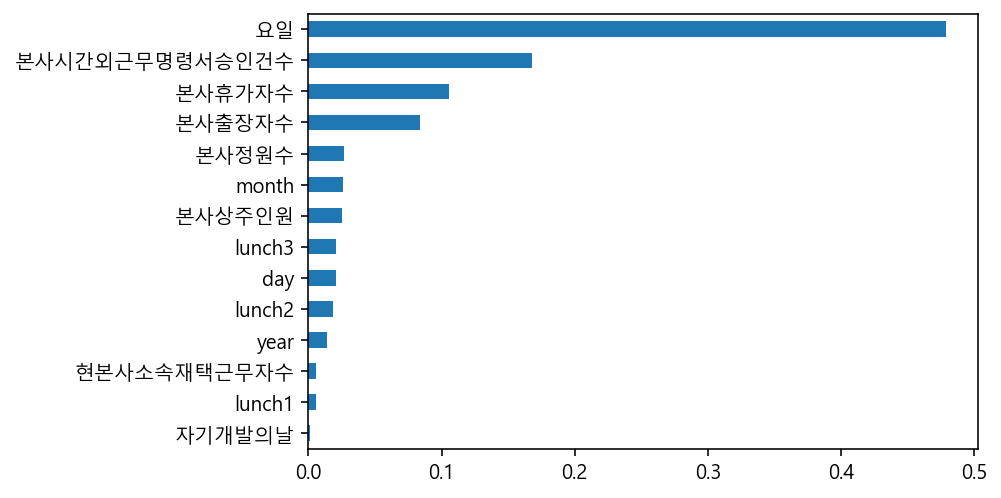

In [704]:
importances_rf = pd.Series(rf.feature_importances_, index=train_X1.columns)

sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf.plot(kind='barh')

In [705]:
fit_X1.drop(['자기개발의날', 'lunch1'], axis=1, inplace=True)
valid_X1.drop(['자기개발의날', 'lunch1'], axis=1, inplace=True)
test_X1.drop(['자기개발의날', 'lunch1'], axis=1, inplace=True)

중요도가 낮은 변수를 제거하여 차원을 축소하였습니다.

**XGBoost Modeling**

In [706]:
lunch_xgb_clf = xgb.XGBRegressor(n_jobs=-1)
lunch_params_xgb = {
    'learning_rate':[0.01],
    'n_estimators':[1000],
    'max_depth':[3, 5],
    'colsample_bytree':[0.5, 0.8],
    'subsample':[0.5, 0.8]
}

lunch_xgb_gridmod = GridSearchCV(estimator=lunch_xgb_clf,
                          param_grid=lunch_params_xgb,
                          cv=5,
                          scoring='neg_mean_absolute_error')

lunch_xgb_gridmod.fit(fit_X1, fit_y1)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=-1,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parame

In [750]:
pd.DataFrame(lunch_xgb_gridmod.cv_results_).sort_values('rank_test_score').drop('params', axis=1).head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,1.314,0.346,0.007,0.003,0.800,0.010,3,1000,0.800,-72.294,-71.543,-65.815,-73.325,-60.152,-68.626,4.975,1
7,1.922,0.499,0.011,0.003,0.800,0.010,5,1000,0.800,-72.821,-70.451,-66.170,-72.393,-61.859,-68.739,4.169,2
6,1.727,0.441,0.013,0.003,0.800,0.010,5,1000,0.500,-72.948,-70.352,-66.522,-72.291,-62.016,-68.826,4.075,3


In [708]:
lunch_xgb_best = lunch_xgb_gridmod.best_estimator_

In [709]:
# 모델예측값
fit_y1_pred = lunch_xgb_best.predict(fit_X1)
valid_y1_pred = lunch_xgb_best.predict(valid_X1)

In [710]:
print_score(fit_y1, fit_y1_pred, 'Fit')
print_score(valid_y1, valid_y1_pred, 'Valid')


Fit set modeling Result:
MAE:  48.79
RMSE:  64.18
-----------------------------------------------

Valid set modeling Result:
MAE:  68.73
RMSE:  92.15
-----------------------------------------------


모델링을 진행한 후 Valid세트를 이용하여 모델의 성과를 확인합니다.

<AxesSubplot:xlabel='Pred', ylabel='Actual'>

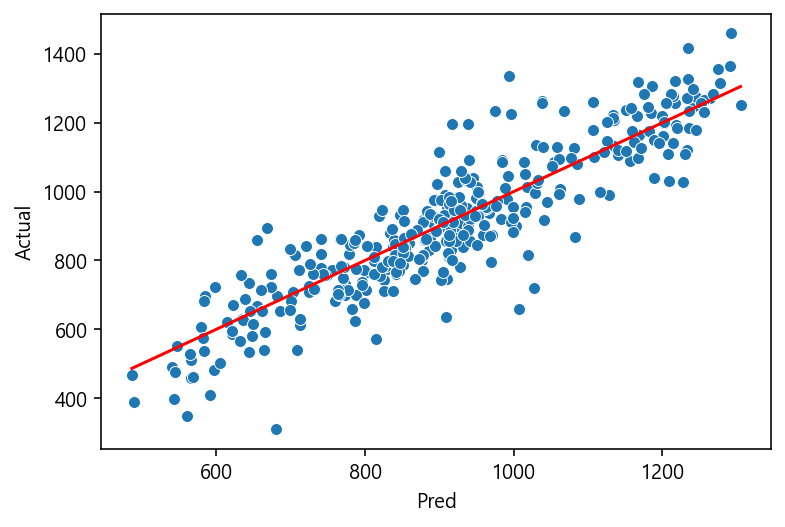

In [711]:
sns.scatterplot(data=pd.DataFrame({'Actual':valid_y1,
                                  'Pred':valid_y1_pred}),
               x='Pred', y='Actual')

x = np.linspace(np.min(valid_y1_pred), np.max(valid_y1_pred), 2)
plt.plot(x, x, '-r')

x축엔 valid세트에 대한 모델 예측값을, y축엔 실제 값을 두고 Scatter plot을 이용하여 모델 성과를 시각적으로 확인합니다.

# 석식계 모델링

In [768]:
train_X2 = train.drop(['석식계', '중식계'], axis=1)
train_y2 = train['석식계']

fit_X2, valid_X2, fit_y2, valid_y2 = train_test_split(train_X2, train_y2, test_size=0.3, random_state=802, stratify=train_X2['자기개발의날'])

test_X2 = test.drop(['석식계', '중식계'], axis=1)
test_y2 = test['석식계']

In [769]:
fit_X2['중식계_pred'] = fit_y1_pred
valid_X2['중식계_pred'] = valid_y1_pred

EDA에서 살펴본 대로 중식계와 석식계는 양의 상관관계를 가지기 때문에 앞서 중식계 모델을 통해서 예측한 예측값을 석식계 예측 모델을 위한 예측변수로 추가 시켜 주었습니다.

RandomForestRegressor(random_state=802)

<AxesSubplot:>

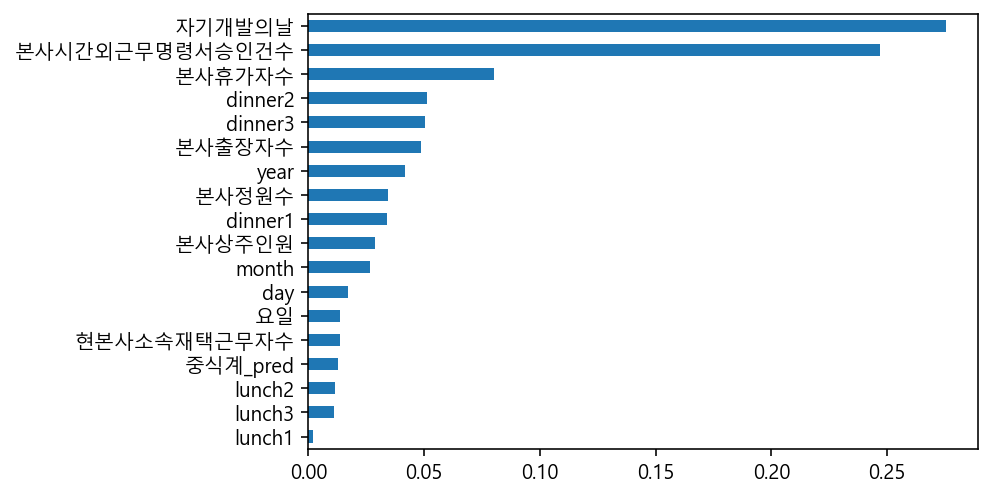

In [722]:
rf = RandomForestRegressor(random_state=802)
rf.fit(fit_X2, fit_y2)

importances_rf = pd.Series(rf.feature_importances_, index=fit_X2.columns)

sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf.plot(kind='barh')

In [770]:
fit_X2.drop(['lunch1'], axis=1, inplace=True)
valid_X2.drop(['lunch1'], axis=1, inplace=True)
test_X2.drop(['lunch1'], axis=1, inplace=True)

중요도가 낮은 변수를 제거하여 차원을 축소하였습니다.

**XGBoost Modeling**

In [763]:
dinner_xgb_clf = xgb.XGBRegressor(n_jobs=-1)
dinner_params_xgb = {
    'learning_rate':[0.01],
    'n_estimators':[1000, 2000],
    'max_depth':[3,5],
    'colsample_bytree':[0.5, 0.8],
    'subsample':[0.5, 0.8]
}

dinner_xgb_gridmod = GridSearchCV(estimator=dinner_xgb_clf,
                          param_grid=dinner_params_xgb,
                          cv=5,
                          scoring='neg_mean_absolute_error')

dinner_xgb_gridmod.fit(fit_X2, fit_y2)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=-1,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parame

In [749]:
pd.DataFrame(dinner_xgb_gridmod.cv_results_).sort_values('rank_test_score').drop('params', axis=1).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,3.013,0.272,0.013,0.003,0.800,0.010,3,2000,0.800,-42.535,-50.188,-42.230,-45.084,-49.435,-45.894,3.357,1
7,3.854,0.449,0.015,0.005,0.500,0.010,5,2000,0.800,-42.512,-50.425,-41.699,-45.050,-50.881,-46.113,3.870,2
10,2.988,0.582,0.010,0.004,0.800,0.010,3,2000,0.500,-42.255,-50.569,-42.580,-45.609,-49.582,-46.119,3.450,3
15,4.574,0.433,0.017,0.004,0.800,0.010,5,2000,0.800,-42.967,-49.542,-42.392,-45.345,-50.539,-46.157,3.337,4
13,2.265,0.310,0.012,0.004,0.800,0.010,5,1000,0.800,-42.376,-49.407,-42.909,-45.745,-50.695,-46.226,3.351,5


In [764]:
dinner_xgb_best = dinner_xgb_gridmod.best_estimator_

In [765]:
fit_y2_pred = dinner_xgb_best.predict(fit_X2)
valid_y2_pred = dinner_xgb_best.predict(valid_X2)

In [727]:
print_score(fit_y2, fit_y2_pred, 'Fit')
print_score(valid_y2, valid_y2_pred, 'Valid')


Fit set modeling Result:
MAE:  26.08
RMSE:  36.61
-----------------------------------------------

Valid set modeling Result:
MAE:  32.6
RMSE:  46.76
-----------------------------------------------


<AxesSubplot:xlabel='Pred', ylabel='Actual'>

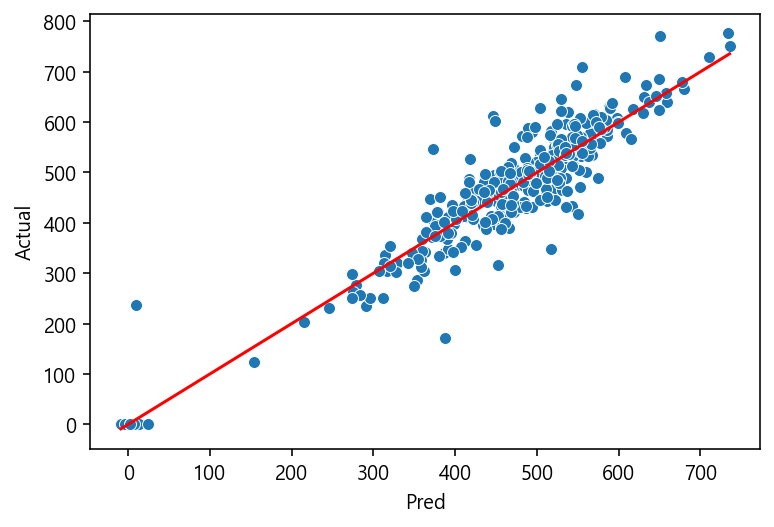

In [728]:
sns.scatterplot(data=pd.DataFrame({'Actual':valid_y2,
                                  'Pred':valid_y2_pred}),
               x='Pred', y='Actual')

x = np.linspace(np.min(valid_y2_pred), np.max(valid_y2_pred), 2)
plt.plot(x, x, '-r')

석식계 예측 모델의 성과를 시각화 합니다.

In [732]:
test_y1_pred = lunch_xgb_best.predict(test_X1)
test_X2['중식계_pred'] = test_y1_pred

In [740]:
test_y2_pred = dinner_xgb_best.predict(test_X2)

앞서 생성한 중식계와 석식계 모델을 이용하여 테스트 세트의 예측을 진행합니다.

In [741]:
submission = pd.read_csv('sample_submission.csv')

In [743]:
submission['중식계'] = test_y1_pred
submission['석식계'] = test_y2_pred

In [745]:
submission.to_csv('Final_submission.csv', index=False)